# Part 1: Training a Custom CNN on CIFAR-10

Develop a CNN with 2-3 convolutional layers, each followed by ReLU and pooling, and 2-3 fully connected MLP layers. Use filters sized as powers of two (16-256), with odd dimensions. Select an optimizer, use batch sizes of 32-128, apply dropout and regularization, implement real-time data augmentation, and train for at least 100 epochs to evaluate testing results.

In [1]:
import os
import pickle
import numpy as np
import torch
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Setting the device to GPU 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda:0


In [3]:
# Load a single CIFAR-10 batch
def load_batch(file_path):
    with open(file_path, 'rb') as file:
        batch = pickle.load(file, encoding='bytes')
    return batch

In [4]:
# Converting labels to one-hot encoding
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

In [5]:
# Load a single batch
file = '/home/pthapa2/snap/padam/Project2/cifar-10-batches-py/data_batch_1'
data_batch_1 = load_batch(file)

# Inspect the data structure
print(f'Type of data_batch_1: {type(data_batch_1)}')
print(f'Keys in data_batch_1: {data_batch_1.keys()}')

Type of data_batch_1: <class 'dict'>
Keys in data_batch_1: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [6]:
for item in data_batch_1:
    print(f'{item}: {type(data_batch_1[item])}')

print('Labels:', set(data_batch_1[b'labels']))

b'batch_label': <class 'bytes'>
b'labels': <class 'list'>
b'data': <class 'numpy.ndarray'>
b'filenames': <class 'list'>
Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [7]:
# Load metadata for label names
meta_file = '/home/pthapa2/snap/padam/Project2/cifar-10-batches-py/batches.meta'
meta_data = load_batch(meta_file)

# Display label names
print('Label names:', [name.decode('utf-8') for name in meta_data[b'label_names']])

Label names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [8]:
# Concatenate all training batches
all_data, all_labels = [], []
for batch_num in range(1, 6):
    batch_filename = f"/home/pthapa2/snap/padam/Project2/cifar-10-batches-py/data_batch_{batch_num}"
    batch_data = load_batch(batch_filename)
    all_data.append(batch_data[b'data'])
    all_labels.extend(batch_data[b'labels'])

x_train = np.vstack(all_data)
y_train = np.array(all_labels)

print("Training data shape before reshape:", x_train.shape)
x_train = x_train.reshape(len(x_train), 3, 32, 32)
print("Training data shape after reshape:", x_train.shape)

Training data shape before reshape: (50000, 3072)
Training data shape after reshape: (50000, 3, 32, 32)


#### So, The dataset consists of 50,000 training samples, each originally having 3,072 features. These samples have been reshaped into dimensions of (50,000, 3, 32, 32), representing the format (number of samples, channels, height, width) for image processing.

In [9]:
# Prepare training data for PyTorch
x_train = x_train.astype('float32') / 255.0
y_train_one_hot = one_hot_encode(y_train)

train_dataset = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train_one_hot))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [10]:
# Load and process test data
test_file = '/home/pthapa2/snap/padam/Project2/cifar-10-batches-py/test_batch'
test_data = load_batch(test_file)
x_test = test_data[b'data'].astype('float32') / 255.0
y_test = np.array(test_data[b'labels'])
print("Test data shape before reshape:", x_test.shape)
x_test = x_test.reshape(len(x_test), 3, 32, 32)
y_test_one_hot = one_hot_encode(y_test)

test_dataset = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test_one_hot))
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("Test data shape after reshape:", x_test.shape)

Test data shape before reshape: (10000, 3072)
Test data shape after reshape: (10000, 3, 32, 32)


### REPORTING:

In [11]:
# REPORTING
print("Data Type: Images")
print("Color Type: RGB")
print("Number of Classes:", len(set(y_train)))
print("Number of Samples:", len(x_train) + len(x_test))
print("Each Sample Dimensions:", x_train.shape[1:])
print("Training Size:", len(x_train))
print("Testing Size:", len(x_test))

Data Type: Images
Color Type: RGB
Number of Classes: 10
Number of Samples: 60000
Each Sample Dimensions: (3, 32, 32)
Training Size: 50000
Testing Size: 10000


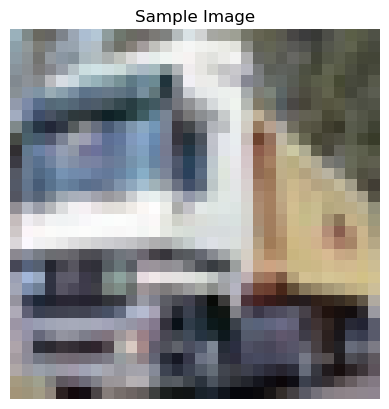

In [12]:
# sample image from the dataset
import matplotlib.pyplot as plt

def show_sample_image(data, index=1):
    img = data[index].reshape(3, 32, 32).transpose(1, 2, 0)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Sample Image')
    plt.show()

show_sample_image(x_train)

In [13]:
# Defining real-time data augmentation transformations for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

# Define transformations for testing (no augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [14]:
# Load datasets
data_dir = './data'
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(32, 32), padding=4)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [16]:
testset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [17]:
# Split the training set into training and validation sets
total_train_size = len(trainset)
val_size = int(0.1 * total_train_size)  # 10% for validation
train_size = total_train_size - val_size

In [18]:
from torch.utils.data import random_split
train_subset, val_subset = random_split(trainset, [train_size, val_size])

In [19]:
# Create DataLoaders for each subset
num_workers = 8
trainloader = DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=num_workers, pin_memory=True)
valloader = DataLoader(val_subset, batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=num_workers, pin_memory=True)


In [20]:
#!pip install torchsummary
from torchsummary import summary


In [21]:
# Define the CNN model
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256*4*4,512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,10)

    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=self.pool(F.relu(self.conv3(x)))
        x=x.view(-1 ,256 *4 *4)
        x=F.relu(self.fc1(x))
        x=self.dropout(x)
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

# Instantiating the model 
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model0=CustomCNN().to(device)

# model summary
summary(model0,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]           9,280
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 256, 8, 8]         147,712
         MaxPool2d-6            [-1, 256, 4, 4]               0
            Linear-7                  [-1, 512]       2,097,664
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 128]          65,664
           Linear-10                   [-1, 10]           1,290
Total params: 2,322,058
Trainable params: 2,322,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.48
Params size (MB): 8.86
Estimat

In [22]:
# Function to calculate accuracy
def accuracy(predictions, labels):
    return (predictions.argmax(dim=1) == labels).float().mean().item()

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model0.parameters(), lr=0.001, weight_decay=1e-5)

In [24]:
def train(dataloader, model, criterion, optimizer):
    model.train()
    total_loss = 0
    total_accuracy = 0
    for X, Y in dataloader:
        X, Y = X.to(device), Y.to(device)

        # Forward pass
        pred = model(X)
        loss = criterion(pred, Y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += (pred.argmax(dim=1) == Y).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader.dataset)

    return avg_loss, avg_accuracy

In [25]:
def validate(dataloader, model, criterion):
    model.eval()
    total_loss = 0
    total_accuracy = 0
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            pred = model(X)
            loss = criterion(pred, Y)

            total_loss += loss.item()
            total_accuracy += (pred.argmax(dim=1) == Y).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader.dataset)

    return avg_loss, avg_accuracy

In [26]:
# Evaluation on test set after training is complete
def test(dataloader, model):
    model.eval()
    total_accuracy = 0
    with torch.no_grad():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)
            pred = model(X)
            total_accuracy += (pred.argmax(dim=1) == Y).sum().item()

    avg_accuracy = total_accuracy / len(dataloader.dataset)
    return avg_accuracy

In [27]:
# # Training loop with plotting data collection
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)

# num_epochs=100 
# train_losses=[]
# train_accuracies=[]
# val_losses=[]
# val_accuracies=[]

# for epoch in range(num_epochs):
#     train_loss ,train_acc=train(trainloader, model0, criterion, optimizer)
#     val_loss ,val_acc=validate(valloader, model0, criterion)

#     train_losses.append(train_loss)
#     train_accuracies.append(train_acc)
#     val_losses.append(val_loss)
#     val_accuracies.append(val_acc)

#     print(f'Epoch {epoch+1}/{num_epochs}, '
#           f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
#           f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Made better function as run_experiment:
def run_experiment(trainloader, testloader, model_class):
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    
    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 100
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(trainloader, model, criterion, optimizer)
        val_loss, val_acc = validate(valloader, model, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Evaluate on the test set
    test_acc = test(testloader, model)
    print(f'The final result of testing accuracy for CustomCNN after training for {num_epochs} epochs is {test_acc * 100:.2f}%')

print("Experiment with Initial Custom CNN:")
run_experiment(trainloader, testloader, CustomCNN)

Experiment with Initial Custom CNN:
Epoch 1/100, Train Loss: 1.7827, Train Acc: 0.3309, Val Loss: 1.5528, Val Acc: 0.4304
Epoch 2/100, Train Loss: 1.4851, Train Acc: 0.4572, Val Loss: 1.3845, Val Acc: 0.5030
Epoch 3/100, Train Loss: 1.3275, Train Acc: 0.5186, Val Loss: 1.2847, Val Acc: 0.5392
Epoch 4/100, Train Loss: 1.2223, Train Acc: 0.5632, Val Loss: 1.1122, Val Acc: 0.6048
Epoch 5/100, Train Loss: 1.1286, Train Acc: 0.5992, Val Loss: 1.0945, Val Acc: 0.6198
Epoch 6/100, Train Loss: 1.0669, Train Acc: 0.6231, Val Loss: 1.0006, Val Acc: 0.6464
Epoch 7/100, Train Loss: 1.0175, Train Acc: 0.6392, Val Loss: 0.9604, Val Acc: 0.6666
Epoch 8/100, Train Loss: 0.9706, Train Acc: 0.6604, Val Loss: 0.9099, Val Acc: 0.6868
Epoch 9/100, Train Loss: 0.9338, Train Acc: 0.6724, Val Loss: 0.8982, Val Acc: 0.6940
Epoch 10/100, Train Loss: 0.9045, Train Acc: 0.6850, Val Loss: 0.8918, Val Acc: 0.6954
Epoch 11/100, Train Loss: 0.8805, Train Acc: 0.6942, Val Loss: 0.8244, Val Acc: 0.7198
Epoch 12/100, Tr

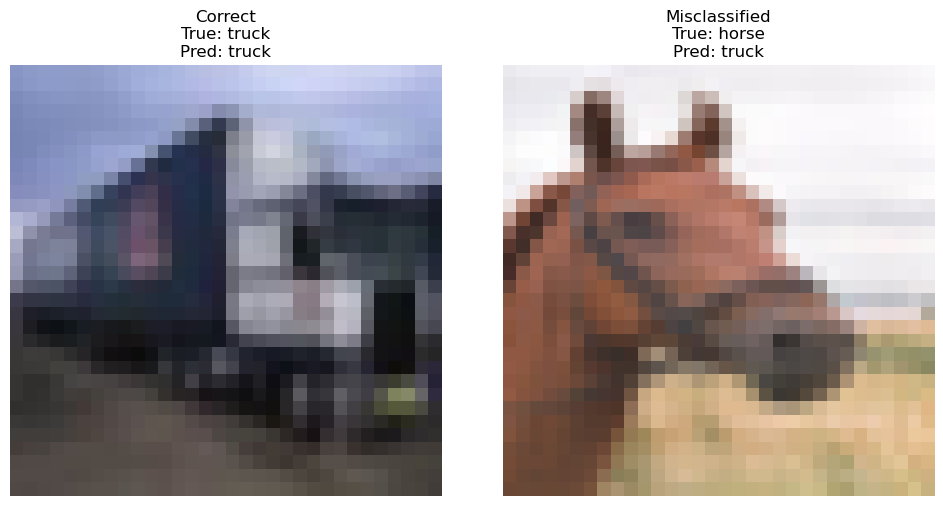

In [63]:
import random

def imshow(img, ax):
    ax.imshow(np.transpose((img / 2 + 0.5).numpy(), (1, 2, 0)))
    ax.axis('off')

def plot_examples(model, dataloader, classes, device):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    _, predicted = torch.max(model(images), 1)

    correct_index = random.choice((predicted == labels).nonzero(as_tuple=True)[0]).item()
    misclassified_index = random.choice((predicted != labels).nonzero(as_tuple=True)[0]).item()

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    for idx, ax, title in zip([correct_index, misclassified_index], axes, ["Correct", "Misclassified"]):
        imshow(images[idx].cpu(), ax)
        ax.set_title(f"{title}\nTrue: {classes[labels[idx].item()]}\nPred: {classes[predicted[idx].item()]}")

    plt.tight_layout()
    plt.show()

# class names for CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

# Call the function to plot classification examples
plot_examples(model0, testloader, classes, device)

# Part 2 -- Graduate Students

For each of the following experiments run 10-20 epocs and observe the cost function. Determine the best setup based on the runs.

**Did for 30 epochs to see the broader view, because at one point Increasing  Filter Size CNN gave me the best accuracy by 1-2% on 20 epochs while now with some modifications SmallFilterSizeCNN is giving me the best results.**

1. Experiment with all convolutional layers having the same small filter size (e.g. 3x3)
2. Experiment with all convolutional layers having the same large filter size (e.g. 15x15)
3. Experiment with convolutional layers with increasing filter size (e.g. 3x3, 5x5, 7x7)
4. Experiment with convolutional layers with decreasing filter size (e.g. 7x7, 5x5, 3x3)
5. Experiment with L1 regularization, L2 regularization, dropout combination.
6. Experiment with and without data augmentation.

7. Generate a short report on based on the above experiment and upload it with your code . You can simply tabulate your results and provide a short analysis.


##### 1. Experiment with all convolutional layers having the same small filter size (e.g. 3x3)


In [29]:
class SmallFilterCNN(nn.Module):
    def __init__(self):
        super(SmallFilterCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model1 = SmallFilterCNN().to(device)

# model summary
summary(model1,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]           9,280
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 256, 8, 8]         147,712
         MaxPool2d-6            [-1, 256, 4, 4]               0
            Linear-7                  [-1, 512]       2,097,664
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 128]          65,664
           Linear-10                   [-1, 10]           1,290
Total params: 2,322,058
Trainable params: 2,322,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.48
Params size (MB): 8.86
Estimat

In [46]:
def run_experiment(trainloader, testloader, model_class):
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    
    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 30
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(trainloader, model, criterion, optimizer)
        val_loss, val_acc = validate(valloader, model, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Evaluate on the test set
    test_acc = test(testloader, model)
    print(f'The final result of testing accuracy for SmallFilterCNN model after training for {num_epochs} epochs is {test_acc * 100:.2f}%')

print("Experiment with same Smaller Filter size:")
run_experiment(trainloader, testloader, SmallFilterCNN)

Experiment with same Smaller Filter size:


Epoch 1/30, Train Loss: 1.8945, Train Acc: 0.3257, Val Loss: 1.5601, Val Acc: 0.4254
Epoch 2/30, Train Loss: 1.6169, Train Acc: 0.4527, Val Loss: 1.3732, Val Acc: 0.4990
Epoch 3/30, Train Loss: 1.4687, Train Acc: 0.5188, Val Loss: 1.2977, Val Acc: 0.5230
Epoch 4/30, Train Loss: 1.3709, Train Acc: 0.5621, Val Loss: 1.1017, Val Acc: 0.6110
Epoch 5/30, Train Loss: 1.2906, Train Acc: 0.5980, Val Loss: 1.0726, Val Acc: 0.6254
Epoch 6/30, Train Loss: 1.2334, Train Acc: 0.6258, Val Loss: 0.9841, Val Acc: 0.6608
Epoch 7/30, Train Loss: 1.1950, Train Acc: 0.6409, Val Loss: 0.9443, Val Acc: 0.6672
Epoch 8/30, Train Loss: 1.1587, Train Acc: 0.6569, Val Loss: 0.9175, Val Acc: 0.6858
Epoch 9/30, Train Loss: 1.1316, Train Acc: 0.6695, Val Loss: 0.8846, Val Acc: 0.6930
Epoch 10/30, Train Loss: 1.1087, Train Acc: 0.6819, Val Loss: 0.8946, Val Acc: 0.6940
Epoch 11/30, Train Loss: 1.0835, Train Acc: 0.6922, Val Loss: 0.8372, Val Acc: 0.7120
Epoch 12/30, Train Loss: 1.0700, Train Acc: 0.6979, Val Loss: 0

##### 2. Experiment with all convolutional layers having the same large filter size (e.g. 15x15)


In [31]:
class LargeFilterCNN(nn.Module):
    def __init__(self):
        super(LargeFilterCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=15, padding=7)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=15, padding=7)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=15, padding=7)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model2 = LargeFilterCNN().to(device)
summary(model2,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]          10,816
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]         230,464
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 256, 8, 8]       3,686,656
         MaxPool2d-6            [-1, 256, 4, 4]               0
            Linear-7                  [-1, 512]       2,097,664
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 128]          65,664
           Linear-10                   [-1, 10]           1,290
Total params: 6,092,554
Trainable params: 6,092,554
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.48
Params size (MB): 23.24
Estima

In [47]:
def run_experiment(trainloader, testloader, model_class):
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    
    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 30
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(trainloader, model, criterion, optimizer)
        val_loss, val_acc = validate(valloader, model, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Evaluate on the test set
    test_acc = test(testloader, model)
    print(f'The final result of testing accuracy for LargeFilterCNN model after training for {num_epochs} epochs is {test_acc * 100:.2f}%')

print("Experiment with same Large filter size:")
run_experiment(trainloader, testloader, LargeFilterCNN)

Experiment with same Large filter size:
Epoch 1/30, Train Loss: 2.0706, Train Acc: 0.2412, Val Loss: 1.8866, Val Acc: 0.3014
Epoch 2/30, Train Loss: 1.8458, Train Acc: 0.3491, Val Loss: 1.6409, Val Acc: 0.4000
Epoch 3/30, Train Loss: 1.7358, Train Acc: 0.4122, Val Loss: 1.5533, Val Acc: 0.4460
Epoch 4/30, Train Loss: 1.6623, Train Acc: 0.4481, Val Loss: 1.5330, Val Acc: 0.4614
Epoch 5/30, Train Loss: 1.6162, Train Acc: 0.4688, Val Loss: 1.5127, Val Acc: 0.4620
Epoch 6/30, Train Loss: 1.5802, Train Acc: 0.4885, Val Loss: 1.4163, Val Acc: 0.4924
Epoch 7/30, Train Loss: 1.5453, Train Acc: 0.5011, Val Loss: 1.3872, Val Acc: 0.5152
Epoch 8/30, Train Loss: 1.5249, Train Acc: 0.5120, Val Loss: 1.3453, Val Acc: 0.5364
Epoch 9/30, Train Loss: 1.5048, Train Acc: 0.5216, Val Loss: 1.3259, Val Acc: 0.5318
Epoch 10/30, Train Loss: 1.4970, Train Acc: 0.5265, Val Loss: 1.2910, Val Acc: 0.5378
Epoch 11/30, Train Loss: 1.4780, Train Acc: 0.5379, Val Loss: 1.2980, Val Acc: 0.5430
Epoch 12/30, Train Loss

##### 3. Experiment with convolutional layers with increasing filter size (e.g. 3x3, 5x5, 7x7)

In [33]:
class IncreasingFilterCNN(nn.Module):
    def __init__(self):
        super(IncreasingFilterCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=7, padding=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256*4*4,512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1,256*4*4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model3 = IncreasingFilterCNN().to(device)
summary(model3,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          25,664
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 256, 8, 8]         803,072
         MaxPool2d-6            [-1, 256, 4, 4]               0
            Linear-7                  [-1, 512]       2,097,664
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 128]          65,664
           Linear-10                   [-1, 10]           1,290
Total params: 2,993,802
Trainable params: 2,993,802
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.48
Params size (MB): 11.42
Estima

In [45]:
def run_experiment(trainloader, testloader, model_class):
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    
    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 30
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(trainloader, model, criterion, optimizer)
        val_loss, val_acc = validate(valloader, model, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Evaluate on the test set
    test_acc = test(testloader, model)
    print(f'The final result of testing accuracy for IncreasingFilterCNN model after training for {num_epochs} epochs is {test_acc * 100:.2f}%')

print("Experiment with Increasing filter size:")
run_experiment(trainloader, testloader, IncreasingFilterCNN)

Experiment with Increasing filter size:


Epoch 1/30, Train Loss: 1.9254, Train Acc: 0.2930, Val Loss: 1.6431, Val Acc: 0.3902
Epoch 2/30, Train Loss: 1.5660, Train Acc: 0.4597, Val Loss: 1.3500, Val Acc: 0.5184
Epoch 3/30, Train Loss: 1.4191, Train Acc: 0.5277, Val Loss: 1.2672, Val Acc: 0.5510
Epoch 4/30, Train Loss: 1.3309, Train Acc: 0.5669, Val Loss: 1.1925, Val Acc: 0.5818
Epoch 5/30, Train Loss: 1.2736, Train Acc: 0.5950, Val Loss: 1.0885, Val Acc: 0.6154
Epoch 6/30, Train Loss: 1.2224, Train Acc: 0.6186, Val Loss: 1.1089, Val Acc: 0.6220
Epoch 7/30, Train Loss: 1.1702, Train Acc: 0.6395, Val Loss: 0.9846, Val Acc: 0.6584
Epoch 8/30, Train Loss: 1.1414, Train Acc: 0.6518, Val Loss: 0.9323, Val Acc: 0.6758
Epoch 9/30, Train Loss: 1.1151, Train Acc: 0.6664, Val Loss: 0.9271, Val Acc: 0.6778
Epoch 10/30, Train Loss: 1.0928, Train Acc: 0.6782, Val Loss: 0.8955, Val Acc: 0.6932
Epoch 11/30, Train Loss: 1.0731, Train Acc: 0.6852, Val Loss: 0.9366, Val Acc: 0.6708
Epoch 12/30, Train Loss: 1.0483, Train Acc: 0.6950, Val Loss: 0

##### 4. Experiment with convolutional layers with decreasing filter size (e.g. 7x7, 5x5, 3x3)

In [35]:
class DecreasingFilterCNN(nn.Module):
    def __init__(self):
        super(DecreasingFilterCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=7, padding=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model4 = DecreasingFilterCNN().to(device)
summary(model4,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]           2,368
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          25,664
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 256, 8, 8]         147,712
         MaxPool2d-6            [-1, 256, 4, 4]               0
            Linear-7                  [-1, 512]       2,097,664
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 128]          65,664
           Linear-10                   [-1, 10]           1,290
Total params: 2,340,362
Trainable params: 2,340,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.48
Params size (MB): 8.93
Estimat

In [48]:
def run_experiment(trainloader, testloader, model_class):
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    
    model = model_class().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 30
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(trainloader, model, criterion, optimizer)
        val_loss, val_acc = validate(valloader, model, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Evaluate on the test set
    test_acc = test(testloader, model)
    print(f'The final result of testing accuracy for DecreasingFilterCNN model after training for {num_epochs} epochs is {test_acc * 100:.2f}%')

print("Experiment with Increasing filter size:")
run_experiment(trainloader, testloader, DecreasingFilterCNN)

Experiment with Increasing filter size:


Epoch 1/30, Train Loss: 1.9483, Train Acc: 0.3123, Val Loss: 1.6519, Val Acc: 0.4026
Epoch 2/30, Train Loss: 1.6495, Train Acc: 0.4448, Val Loss: 1.4066, Val Acc: 0.4998
Epoch 3/30, Train Loss: 1.5039, Train Acc: 0.5098, Val Loss: 1.2706, Val Acc: 0.5502
Epoch 4/30, Train Loss: 1.4109, Train Acc: 0.5573, Val Loss: 1.1825, Val Acc: 0.5928
Epoch 5/30, Train Loss: 1.3347, Train Acc: 0.5923, Val Loss: 1.1459, Val Acc: 0.6046
Epoch 6/30, Train Loss: 1.2860, Train Acc: 0.6164, Val Loss: 1.0324, Val Acc: 0.6508
Epoch 7/30, Train Loss: 1.2434, Train Acc: 0.6349, Val Loss: 1.0060, Val Acc: 0.6510
Epoch 8/30, Train Loss: 1.2108, Train Acc: 0.6501, Val Loss: 1.0133, Val Acc: 0.6476
Epoch 9/30, Train Loss: 1.1843, Train Acc: 0.6638, Val Loss: 0.9610, Val Acc: 0.6684
Epoch 10/30, Train Loss: 1.1627, Train Acc: 0.6705, Val Loss: 0.8947, Val Acc: 0.6892
Epoch 11/30, Train Loss: 1.1447, Train Acc: 0.6789, Val Loss: 0.9026, Val Acc: 0.6838
Epoch 12/30, Train Loss: 1.1236, Train Acc: 0.6894, Val Loss: 0

Reporting:

1. Small Filters (3x3): Showed steady convergence with good generalization, achieving a highest testing accuracy of 80.55%.
2. Large Filters (15x15): Converge more slowly and achieve lower performance, with a test accuracy of 65.49%, likely due to overfitting.
3. Increasing Filter Sizes (3x3, 5x5, 7x7): Shows good convergence with consistent decrease in losses. Achieved the test accuracy of 77.41%, effectively balancing detail capture and broader pattern recognition.
4. Decreasing Filter Sizes (7x7, 5x5, 3x3): Performed well with a test accuracy of 78.81%, but slightly more effective than increasing sizes.

Conclusion: Small filter sizes provide the best balance and performance, making them a strong choice for capturing both fine details and broader patterns.

##### 5. Experiment with L1 regularization, L2 regularization, dropout combination.

In [49]:
class CustomBESTCNN(nn.Module):
    def __init__(self):
        super(CustomBESTCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256*4*4, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # x = self.dropout(x)
        x = self.fc3(x)
        return x

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model5 = CustomBESTCNN().to(device)

In [50]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters(), lr=0.001, weight_decay=1e-5)

# Training function with L1 regularization
def train(dataloader, model, criterion, optimizer):
    model.train()
    total_loss = 0
    total_accuracy = 0
    l1_lambda = 1e-5

    for X, Y in dataloader:
        X, Y = X.to(device), Y.to(device)

        # Forward pass
        pred = model(X)
        loss = criterion(pred, Y)

        # Add L1 regularization
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1_lambda * l1_norm

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += (pred.argmax(dim=1) == Y).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader.dataset)

    return avg_loss, avg_accuracy

In [53]:
def run_experiment(trainloader, testloader, model_class):
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    
    model = model_class().to(device)  # Instantiate the provided model class
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 20
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(trainloader, model, criterion, optimizer)
        val_loss, val_acc = validate(valloader, model, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Evaluate on the test set
    test_acc = test(testloader, model)
    print(f'The final result of testing accuracy with L1/L2 and dropout regularization with CustomBestCNN after training for {num_epochs} epochs is {test_acc * 100:.2f}%')

print("Experiment with L1, L2 and Dropout filter size:")
run_experiment(trainloader, testloader, CustomBESTCNN)

Experiment with L1, L2 and Dropout filter size:


Epoch 1/20, Train Loss: 1.9277, Train Acc: 0.2923, Val Loss: 1.6458, Val Acc: 0.3898
Epoch 2/20, Train Loss: 1.5848, Train Acc: 0.4496, Val Loss: 1.3851, Val Acc: 0.4994
Epoch 3/20, Train Loss: 1.4328, Train Acc: 0.5190, Val Loss: 1.2781, Val Acc: 0.5374
Epoch 4/20, Train Loss: 1.3477, Train Acc: 0.5623, Val Loss: 1.2221, Val Acc: 0.5658
Epoch 5/20, Train Loss: 1.2760, Train Acc: 0.5895, Val Loss: 1.0982, Val Acc: 0.6124
Epoch 6/20, Train Loss: 1.2267, Train Acc: 0.6156, Val Loss: 1.0743, Val Acc: 0.6256
Epoch 7/20, Train Loss: 1.1721, Train Acc: 0.6367, Val Loss: 1.0291, Val Acc: 0.6480
Epoch 8/20, Train Loss: 1.1379, Train Acc: 0.6522, Val Loss: 0.9284, Val Acc: 0.6802
Epoch 9/20, Train Loss: 1.1162, Train Acc: 0.6661, Val Loss: 0.9246, Val Acc: 0.6844
Epoch 10/20, Train Loss: 1.0967, Train Acc: 0.6723, Val Loss: 0.9232, Val Acc: 0.6794
Epoch 11/20, Train Loss: 1.0714, Train Acc: 0.6859, Val Loss: 0.9445, Val Acc: 0.6842
Epoch 12/20, Train Loss: 1.0471, Train Acc: 0.6932, Val Loss: 0

##### 6. Experimentation with and without data augmentation.

In [40]:
import torchvision.transforms as transforms

# defining data augmentation transformations for training
transform_train_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading datasets with data augmentation
trainset_augmented = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_augmented)
trainloader_augmented = DataLoader(trainset_augmented, batch_size=128, shuffle=True, num_workers=4)


Files already downloaded and verified


In [41]:
# transformations for training without augmentation
transform_train_no_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading datasets without data augmentation
trainset_no_aug = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_no_aug)
trainloader_no_aug = DataLoader(trainset_no_aug, batch_size=128, shuffle=True, num_workers=4)


Files already downloaded and verified


In [52]:
def run_experiment(trainloader, testloader):
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    
    model = CustomBESTCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    num_epochs = 20
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(trainloader, model, criterion, optimizer)
        val_loss, val_acc = validate(valloader, model, criterion)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Evaluation on the test set
    test_acc = test(testloader, model)
    print(f'The final result of testing accuracy after training for {num_epochs} epochs is {test_acc * 100:.2f}%')

# with data augmentation
print("Training with Data Augmentation:")
run_experiment(trainloader_augmented, testloader)

# without data augmentation
print("\nTraining without Data Augmentation:")
run_experiment(trainloader_no_aug, testloader)


Training with Data Augmentation:
Epoch 1/20, Train Loss: 1.8797, Train Acc: 0.3352, Val Loss: 1.5786, Val Acc: 0.4350
Epoch 2/20, Train Loss: 1.5874, Train Acc: 0.4665, Val Loss: 1.3201, Val Acc: 0.5276
Epoch 3/20, Train Loss: 1.4227, Train Acc: 0.5360, Val Loss: 1.2074, Val Acc: 0.5708
Epoch 4/20, Train Loss: 1.3237, Train Acc: 0.5792, Val Loss: 1.1096, Val Acc: 0.6040
Epoch 5/20, Train Loss: 1.2573, Train Acc: 0.6091, Val Loss: 0.9912, Val Acc: 0.6548
Epoch 6/20, Train Loss: 1.2090, Train Acc: 0.6304, Val Loss: 0.9463, Val Acc: 0.6746
Epoch 7/20, Train Loss: 1.1704, Train Acc: 0.6514, Val Loss: 0.8892, Val Acc: 0.6944
Epoch 8/20, Train Loss: 1.1308, Train Acc: 0.6682, Val Loss: 0.8683, Val Acc: 0.6994
Epoch 9/20, Train Loss: 1.1127, Train Acc: 0.6764, Val Loss: 0.8249, Val Acc: 0.7180
Epoch 10/20, Train Loss: 1.0899, Train Acc: 0.6866, Val Loss: 0.8200, Val Acc: 0.7200
Epoch 11/20, Train Loss: 1.0657, Train Acc: 0.6949, Val Loss: 0.8087, Val Acc: 0.7260
Epoch 12/20, Train Loss: 1.053

# Short Report:

In [60]:
import pandas as pd

# summarizing the experimental results in the table
results_data = {
    'Experiment': [
        'Initial CustomCNN (100 epochs)',
        'Small Filters (3x3)',
        'Large Filters (15x15)',
        'Increasing Filter Sizes (3x3, 5x5, 7x7)',
        'Decreasing Filter Sizes (7x7, 5x5, 3x3)',
        'L1/L2 Regularization with Dropout',
        'With Data Augmentation',
        'Without Data Augmentation'
    ],
    'Validation Accuracy (%)': [81.94, 74.9, 56.18, 73.6, 72.94, 73.42, 77.6, 52.52],
    'Testing Accuracy (%)': [83.82, 80.55, 65.49, 77.41, 78.81, 77.17, 78.53, 76.86]
}

# pandas dataframe
results_df = pd.DataFrame(results_data)

# Format to two decimal places
formatted_results_df = results_df.style.format({
    'Validation Accuracy (%)': '{:.2f}%',
    'Testing Accuracy (%)': '{:.2f}%'
}).set_table_styles(
    [{'selector': 'th', 'props': [('font-weight', 'bold')]}]
).set_properties(**{'text-align': 'center'}).set_caption("Experimental Results Summary")

formatted_results_df

,Experiment,Validation Accuracy (%),Testing Accuracy (%)
0,Initial CustomCNN (100 epochs),81.94%,83.82%
1,Small Filters (3x3),74.90%,80.55%
2,Large Filters (15x15),56.18%,65.49%
3,"Increasing Filter Sizes (3x3, 5x5, 7x7)",73.60%,77.41%
4,"Decreasing Filter Sizes (7x7, 5x5, 3x3)",72.94%,78.81%
5,L1/L2 Regularization with Dropout,73.42%,77.17%
6,With Data Augmentation,77.60%,78.53%
7,Without Data Augmentation,52.52%,76.86%


In our experiments with different CNN setups on the CIFAR-10 dataset, using small filters (3x3) resulted in the best performance, achieving a high testing accuracy of 80.55%. These filters effectively captured essential details. Data augmentation also played a crucial role by increasing testing accuracy to 78.53%, compared to 76.86% without it, highlighting its importance for generalization.